In [1]:
#imports base
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
import sys
import seaborn as sns
import warnings
from src.utils import *

#sklearn utils
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error

#models
from sklearn.cluster import SpectralClustering

In [2]:
#configuracion
sns.set(color_codes=True)
sns.set_palette(sns.color_palette("PuBuGn_d"))
warnings.filterwarnings('ignore')
sys.path.append('/home/ds/Dropbox/Para mi/EDU/UOC/cajamar2018/code/py/src/')
%matplotlib inline

#pathdata
PATH_DATA = '~/Dropbox/Para mi/EDU/UOC/cajamar2018/data/'

In [3]:
#lectura dataset
df = pd.read_table(PATH_DATA+'/TRAIN.txt', sep=',')
df.head()

,ID_Customer,Imp_Cons_01,Imp_Cons_02,Imp_Cons_03,Imp_Cons_04,Imp_Cons_05,Imp_Cons_06,Imp_Cons_07,Imp_Cons_08,Imp_Cons_09,...,Num_Oper_17,Num_Oper_18,Num_Oper_19,Num_Oper_20,Socio_Demo_01,Socio_Demo_02,Socio_Demo_03,Socio_Demo_04,Socio_Demo_05,Poder_Adquisitivo
0,TR000001,0.0,0.00,0.000000,63.067778,0.0,52.196667,0.0,0.000000,0.00,...,2,0,0,0,09991,1,70.44,3,20,19709.915000
1,TR000002,0.0,100.58,595.454545,10.899000,0.0,39.473636,0.0,62.268571,42.61,...,4,1,0,0,09991,2,71.87,3,29,37497.492167
2,TR000003,0.0,0.00,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.00,...,2,0,0,0,0X301,2,72.48,2,41,4802.970000
3,TR000004,0.0,0.00,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.00,...,0,0,0,0,0X301,2,86.60,3,38,8295.770000
4,TR000005,0.0,0.00,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.00,...,0,0,0,0,09991,2,92.48,4,35,24149.321667


In [4]:
#conteo de clientes diferentes en el conjunto de entrenamiento.
nclientes_train = df.shape[0]
nclientes_train

363834

In [5]:
#definición variables TARGET categóricas, binarias y numéricas:
TARGET           = 'Poder_Adquisitivo'
binary_vars      = ['Socio_Demo_01', 'Socio_Demo_02']
categorical_vars = ['Ind_Prod_%(#)02d'% {"#":x} for x in range(1, 25) ] + binary_vars
numerical_vars   = sorted(list(set(df.columns) - set([TARGET]) - set(categorical_vars) - set(binary_vars) - set(['ID_Customer'])))

In [6]:
#nos aseguramos que las numéricas están bien formateadas
df[numerical_vars] = df[numerical_vars].apply(pd.to_numeric, errors='ignore')

In [7]:
#formateo variables categoricas
for col in categorical_vars: df[col] = df[col].astype('category').cat.as_ordered()

## EDA 

Vamos a analizar las variables numéricas en primer lugar. 

Para ello vamos a generar un informe con los parámetros básicos de cada variable (conteos, medias, cuartiles, ...) y un histograma de cada variable.

Esto nos permitirá identificar a primera vista la distribución que tiene cada variable y la posible presencia de *outliers*.

Analicemos la variable `TARGET`

In [ ]:
#información estadística relevante del cliente
df[TARGET].describe()

El poder adquisitivo medio ronda los 16K. Sin embargo, existe una gran asimetría con clientes con un poder adquisitivo varios órdenes de magnitud mayor.

In [ ]:
#diagrama de densidad del poder adquisitivo
sns.distplot(df[TARGET])

In [ ]:
#diagrama de densidada del poder adquisitivo
sns.distplot(np.log(df[TARGET]), color='#009999')

Observamos que la transformación logarítmica beneficia enormemente la representabilidad de la distribución del `TARGET`.

A continuación extraemos la misma información para el resto de variables numéricas.

In [ ]:
#lista de descripciones estadísticas e histogramas de las variables numéricas
start_time = time.time()

for i, var in enumerate(sorted(numerical_vars)):
    print(df[numerical_vars[i]].describe())
    plt.hist(df[numerical_vars[i]], bins= 1000, color='#009999')
    plt.xlabel('units')
    plt.ylabel('count')
    plt.title('distribución variable : {0}'.format(var))
    plt.show()
    print('\n')
    
print("--- %s seconds ---" % (time.time() - start_time))

---
A continuación vamos a realizar el análisis exploratorio de las variables categóricas.

Éste consistirá en obtener los conteos del número de clientes en cada conjunto para cada categoría; así como obtener un *box-plot* de cada categoría frente al `TARGET` (con el $log$ aplicado).

In [ ]:
#lista de descriptivos y boxplots de las variables numéricas
start_time = time.time()

for i, var in enumerate(sorted(categorical_vars)):
    print(df[var].describe())
    dataplot = pd.concat([np.log(df[TARGET]), df[var]], axis=1)
    f, ax = plt.subplots(figsize=(8, 6))
    fig = sns.boxplot(x=var, y=TARGET, data=dataplot)
    fig.axis(ymin=0);
    print('\n')
    
print("--- %s seconds ---" % (time.time() - start_time))

Salvo la variable `Socio_Demo_01`, el resto de variables tiene un número de categorías bajo (3 la mayoría). Esto facilita su tratamiento, ya que consiguen agrupar un % alto de clientes cada categoría.

La variable `Socio_Demo_01` que es una variable discreta pero con un número muy alto de valores (921) por lo que requiere un tratamiento especial.

In [9]:
df['Socio_Demo_01_mod'] = df['Socio_Demo_01'].replace([np.inf, -np.inf, np.nan], '-99')

In [10]:
conditions = [
    (df['Socio_Demo_01_mod'] == '0X301'),
    #(type(df['Socio_Demo_01']) is not int) & (df['Socio_Demo_01'] != '0X301'),
    (df['Socio_Demo_01_mod'] != '0X301')
]
choices = [
    0, 
    df['Socio_Demo_01_mod']
]
df['Socio_Demo_01_mod'] = np.select(conditions, choices)
df['Socio_Demo_01_mod'] = np.int32(pd.to_numeric(df['Socio_Demo_01_mod']))
df['Socio_Demo_01_mod'] = df['Socio_Demo_01_mod'].astype('category').cat.as_ordered()

Socio_Demo_01_df = df.groupby(['Socio_Demo_01_mod']).agg({TARGET: [min, max, 'mean', 'std', 'median'], 'Socio_Demo_01_mod': ['size']})
Socio_Demo_01_df.head()

Poder_Adquisitivo                               \
                                min            max          mean   
Socio_Demo_01_mod                                                  
-99                         3617.64  169886.010000  14052.403446   
 0                          3603.96  331040.790000  14870.137722   
 11                         4944.62  102551.205750  26900.134800   
 12                         3922.56   77114.612083  20617.374938   
 20                         3783.49  113358.763000  18232.483429   

                                              Socio_Demo_01_mod  
                            std        median              size  
Socio_Demo_01_mod                                                
-99                10238.847755  11843.670000               610  
 0                 11193.437905  12236.523833             15867  
 11                12730.329611  25853.099667               677  
 12                10863.191678  18894.510000               307  
 20                 9994.578845  16467.720000               723

In [11]:
spectral = SpectralClustering(n_clusters=50, 
                                      eigen_solver='arpack',
                                      affinity="nearest_neighbors")

In [12]:
Socio_Demo_01_X = Socio_Demo_01_df.replace([np.inf, -np.inf,  np.nan], 0)


In [13]:
scaler = preprocessing.StandardScaler()
Socio_Demo_01_X = scaler.fit_transform(Socio_Demo_01_X)

In [14]:
clusters = list(spectral.fit_predict(Socio_Demo_01_X))

In [15]:
Socio_Demo_01_df['cluster'] = clusters

In [16]:
Socio_Demo_01_df = Socio_Demo_01_df[['cluster']]
Socio_Demo_01_df = Socio_Demo_01_df.reset_index()

In [17]:
df = pd.merge(df, Socio_Demo_01_df, on='Socio_Demo_01_mod', how='left')

In [18]:
df['cluster_Social_Demo_01'] = df[('cluster', '')].astype('category').cat.as_ordered()
df = df.drop([('cluster', ''), 'Socio_Demo_01_mod', 'Socio_Demo_01'], axis=1)

In [19]:
categorical_vars.append('cluster_Social_Demo_01')
categorical_vars = list(set(categorical_vars) - set(['Socio_Demo_01']))

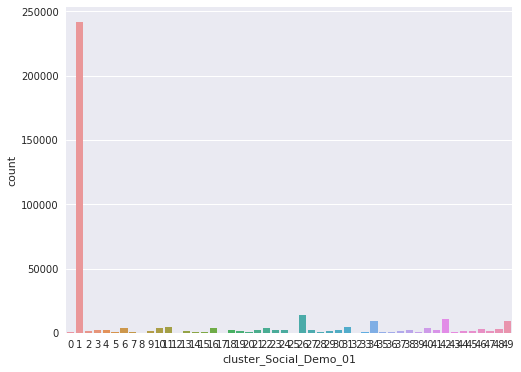

In [20]:
dataplot = pd.concat([np.log(df[TARGET]), df['cluster_Social_Demo_01']], axis=1)
f, ax = plt.subplots(figsize=(8, 6))
fig = sns.countplot(x='cluster_Social_Demo_01', data=dataplot)


----

# Transformación de variables contínuas

Por los *summary* queda claro que existen varios clientes en cada una de las variables que se salen de los cuartiles generales. Puesto que se trata de un tablón con información económica, estos clientes no son necesariamente "outliers", si no que puede tratarse de personas de renta alta/muy alta.

Aquellos clientes que detectemos que exceden el tercer cuartil en un número "alto". Los vamos a marcar con una variable categórica para que el modelo sea capaz de detectar que son clientes "especiales".

La variable `Socio_Demo_05` muestra un valor normal por lo que lo vamos a tratar. El resto de variables las vamos a "normalizar" aplicando el logaritmo.

In [21]:
idx_specials = sorted(list(set(
    [item for sublist in 
     [
         outliers_score(df[numerical_vars[i]])[0].tolist() 
         for i, var in enumerate(list( set(numerical_vars)-set(['Socio_Demo_05']) )) 
     ]  
     for item in sublist])))

In [22]:
#número de clientes "especiales"
df.iloc[idx_specials].shape[0]

45945

In [23]:
#creamos la variable "cliente especial".
df['cliente_especial'] = 'NO'
df.loc[idx_specials, ['cliente_especial']]='SI'

df['cliente_especial'] = df['cliente_especial'] .astype('category').cat.as_ordered()
categorical_vars.append('cliente_especial')

En los *summary* de arriba podemos observar que existe alguna variable cuyo mínimo es menor que 0. Estas variables no pueden transformarse por el $log$, por lo que las excluiremos.

Adicionalmente excluiremos las variables `Num_Oper_`, ya que representan conteos de operaciones y la diferencia entre el máximo y mínimo escala no excede los 3 órdenes de magnitud .

**Importante**: La variable `TARGET` también tiene una distribución poco simétrica (más "*poissonica*" que normal). Debido a que ciertos algoritmos y modelos estadísticos se van a beneficiar de la normalización de la variable le aplicaremos el logaritmo también. Esto implica que el modelo estimará el $log(poderAdquisitivo)$ y tendremos que invertir la transformación para la evaluación de la capacidad predictiva.

In [24]:
vars_2_exclude   = df[numerical_vars].loc[:, df[numerical_vars].apply(lambda x: x < 0).apply(any)].columns.tolist()
numerical_vars.append(TARGET)
vars_2_transform = set(numerical_vars) - set(['Socio_Demo_05']) -set(vars_2_exclude) - set([s for s in numerical_vars if "Num_Oper_" in s])
df_mod = df

for var in vars_2_transform: 
    df_mod[var] = df_mod[var].apply(lambda x: np.log(x + 1))

In [ ]:
start_time = time.time()

for i, var in enumerate(sorted(numerical_vars)):
    print(df[numerical_vars[i]].describe())
    plt.hist(df[numerical_vars[i]], bins= 50, color='#009999')
    plt.xlabel('units')
    plt.ylabel('count')
    plt.title('distribución variable : {0}'.format(var))
    plt.show()
    print('\n')
    
print("--- %s seconds ---" % (time.time() - start_time))

-------------

# Limpieza de datos

En primer lugar vamos a comprobar que no exista ningún nulo.

# Exportado de datos procesados

A continuación exportamos los datos procesados para ser empleados en posteriores scripts.

In [25]:
import pickle

In [28]:
pickle.dump(df_mod, open('dataframe_processed.pkl','wb'))
pickle.dump((numerical_vars, categorical_vars, TARGET), open('vars.pkl','wb'))